## Product feature A/B Testing

### Introduction

I am a Product Data Analyst, working for an online store. I just came out from a meeting where it emerged that the overall conversion rate is 2.8%, which is not bad, but it could be improved by reducing attrition (that is, reducing drop-offs) in the checkout funnel. 
My first objective is to identify a problematic step (in terms of customers’ drop-off) in the conversion funnel; I will analyse the data via Google Analytics. The product manager and the design team will then propose a redesign of a feature in that web-page. 
Once the redesign is completed and the new feature has been implemented by the web development team and is ready to go live into production, my second task will be to design an experiment (an AB test) that will allow us to measure statistically (via hypothesis testing) whether the new feature is actually improving the funnel conversion rate or not.

### Google Analytics

By using Google Analytics I am able to check if any problematic steps occurs during the customer path towards purchase.

![alt text](GA_funnel.png "Funnel")

In this example I do see that only 12% of the customers add payment info and proceed with the next step. We need to address this for example by adding as method of payment Paypal, which will result in maybe a smoother payment process.
We will lead 50% of the merch store traffic to a page with the new feature and the other half with the current one.


### Python

I need to import all the necessary libraries first:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

I simulate my unique visitors as a binomial distribution with two different probabilities.
The sample size has been calculated with the following paramenters:

![alt text](Sample_size.png "Sample size for test and control groups")

In [3]:
np.random.seed(42)
control = np.random.binomial(n=1, p=0.028, size=20000)
test = np.random.binomial(n=1, p=0.035, size=20000)

I want to check numerically how many conversion we obtained in each group. Namely:

In [4]:
df_control = pd.DataFrame({'group': 'control', 'converted': control})
df_control.value_counts()

group    converted
control  0            19450
         1              550
dtype: int64

In [5]:
df_test = pd.DataFrame({'group': 'test', 'converted': test})
df_test.value_counts()

group  converted
test   0            19302
       1              698
dtype: int64

Test statistic in this case is defined as the difference between means of the two groups conversions.

In [6]:
mean_test = np.mean(df_test.converted)
mean_control = np.mean(df_control.converted)
mu_diff = mean_test - mean_control

In [7]:
print(f"mean test:\t{np.mean(df_test.converted)}\nmean control:\t{np.mean(df_control.converted)}\nmu_diff:\t{np.mean(df_test.converted)-np.mean(df_control.converted)}")

mean test:	0.0349
mean control:	0.0275
mu_diff:	0.0074


![alt text](Hypothesis_Test.png "Hypothesis Test")

I merge now the two datasets together in order to run the Permutation test.

In [8]:
df = pd.concat([df_control,df_test]).sample(frac=1).reset_index(drop=True)
df.head(10)

,group,converted
0,test,0
1,test,0
2,control,0
3,control,0
4,test,0
5,control,0
6,test,0
7,test,0
8,test,0
9,test,0


I will first try to do permutation by using the Scipy library and then check the result with an algorithm on mine. If the two results end up to be consistent with each other I will be more confident about the A|B test results.

In [9]:
from scipy.stats import permutation_test

n = 10000

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y,axis=axis)

res = permutation_test((df_test.converted, df_control.converted), statistic, vectorized=True, n_resamples=n, alternative='greater', random_state=42)

print(f"Observed test-statistic:\t{res.statistic}")
print(f"p-value:\t\t\t{res.pvalue*100}%")

Observed test-statistic:	0.0074
p-value:			0.009999000099990002%


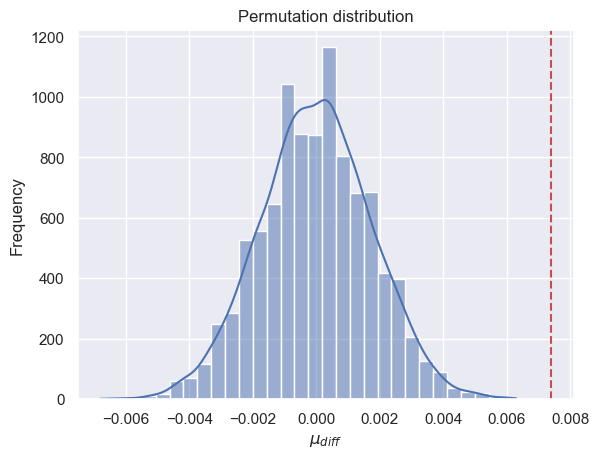

In [24]:
sns.histplot(res.null_distribution, bins=30, kde=True)
plt.title("Permutation distribution")
plt.xlabel(r'$\mu_{diff}$')
plt.ylabel("Frequency")
plt.axvline(res.statistic, 0, 1, color='r', linestyle='--')
plt.show()

In [27]:
#PERMUTATION TEST - PERSONAL ALGORITHM

mu_diff_samples = []
# I select a subset of my dataset containing only poultry and fish data
df_temp = df
# Starting the permutations to collect the u_diff for each samples
for i in range(n):
    # extract a subsample of 50% of data without replacement
    df_sample1 = df_temp.sample(frac=0.5, replace=False)
    # use set() to get indexes of rows that were not extracted from df in previous step
    ix2 = set(df_temp.index) - set(df_sample1.index) # create dataframe with other 50% of data
    df_sample2 = df_temp.iloc[list(ix2)]
    # calculate difference in mean from each sample
    mu_diff_temp = np.mean(df_sample1.converted) - np.mean(df_sample2.converted)
    # append sampled mean difference to mu_diff_samples list
    mu_diff_samples.append(mu_diff_temp)

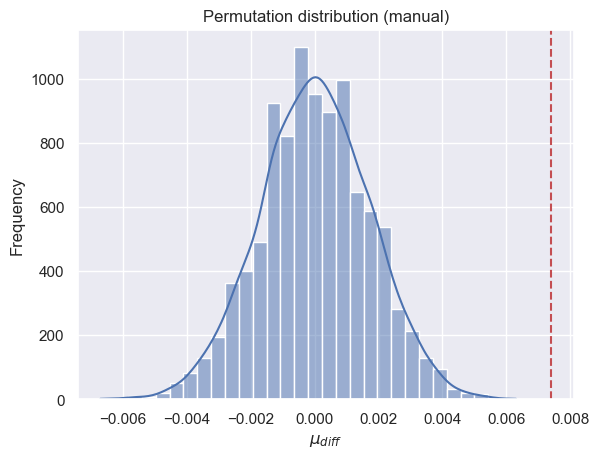

In [26]:
#plot del calcolo manuale
sns.histplot(mu_diff_samples, kde=True, bins=30)
plt.axvline(mu_diff, 0, 1, color='r', linestyle='--')
plt.xlabel(r'$\mu_{diff}$')
plt.ylabel('Frequency')
plt.title('Permutation distribution (manual)')
plt.show()

In [13]:
print('Values more extreme than observed:', sum([el > mu_diff for el in mu_diff_samples]))
p_value = sum([el > mu_diff for el in mu_diff_samples])/n
print('p-value:', p_value*100, "%")

Values more extreme than observed: 0
p-value: 0.0 %


It seems that both algorithms end up with a p-value < $\alpha$.
I save the results in a new dataframe in order to export it as csv in case of further need outside the notebook.

In [14]:
df_mu_diff = pd.DataFrame(mu_diff_samples)
df_mu_diff

,0
0,-0.0018
1,-0.0008
2,0.0031
3,-0.0007
4,0.0007
...,...
9995,0.0039
9996,0.0021
9997,0.0001
9998,-0.0016


In [15]:
df_mu_diff.to_csv('df_mu_diff.csv')

### Results

The results of the A|B test seems to confirm that the difference that occurred in the average conversion rates between Test and Control groups is statistically significant. We have then the 0.009% probabilty that this has been the result of random events. Very low indeed. We then reject the null hypothesis H0 and welcome the alternative H1.
We should then implement globally the new feature so that we do not loose further conversions from customers.